# Analyse des activations

Ce notebook sert à analyser un dataset d'activation de neuronnes

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings


## Configuration

In [3]:
# Fichier csv contenant les activations d'un model
sm_file = "../../data/activations/activations.csv"


# fichier csv contenant les activations de plusieurs model
mm_file = "../../data/activations/multi_mlp.csv"

# Cette variable indique les nombres de neuronnes et le nombre de couche caché 
# elle doit correspondre à celle utilisé pour créer le jeux de données
hidden_sizes = [128, 64] 


In [4]:
activations = pd.read_csv(sm_file)
mean_per_nb = activations.drop(columns=['nb_pred']).groupby("nb_true").mean()

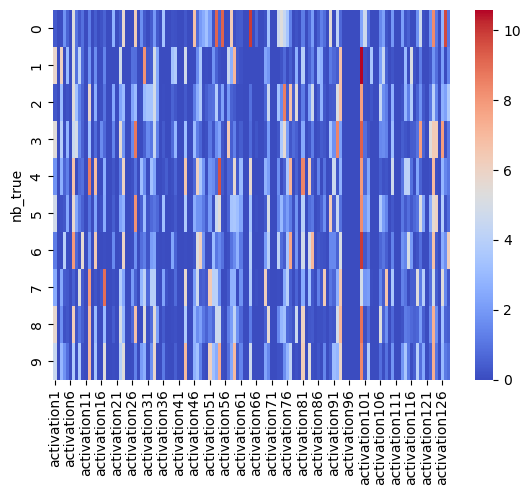

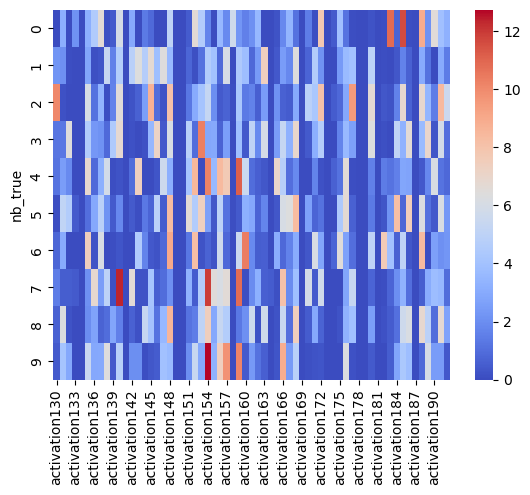

In [5]:

cursor = 0
for i in range(len(hidden_sizes)):
    sns.heatmap(
        mean_per_nb.iloc[:,cursor:cursor+hidden_sizes[i]],
        cmap="coolwarm", fmt=".2f"
        )
    plt.show()
    cursor += hidden_sizes[i]+1

## Analyse en composante principale

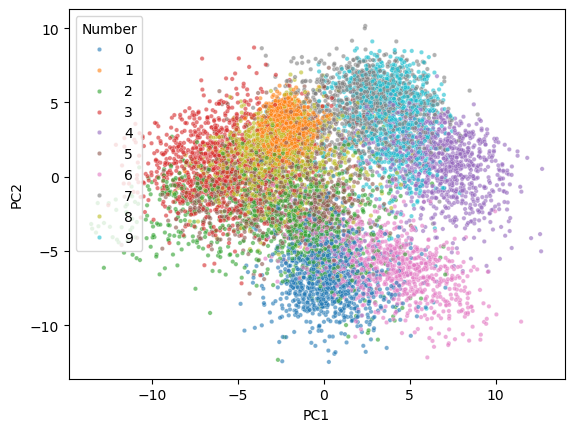

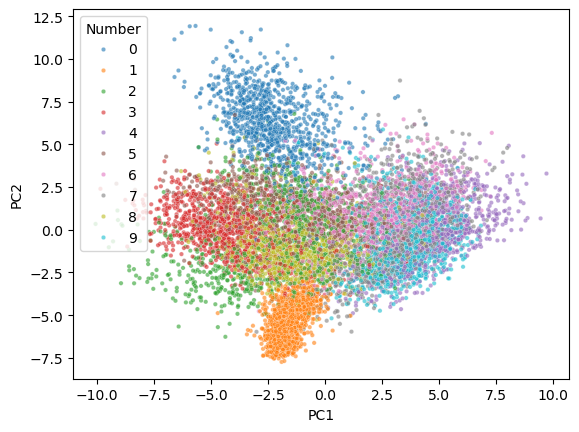

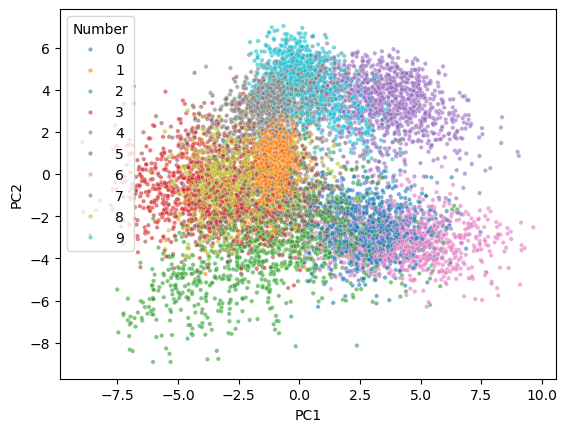

In [6]:
def plot_acp(data, labels):
    # on commence par normaliser les données 
    data_normalized = StandardScaler().fit_transform(data)

    # ensuite on effectue l'ACP avec 2 composantes
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_normalized)

    # transforme les résultats en dataframe 
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Number'] = labels

    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Number',
        palette='tab10',  # Palette de 10 couleurs
        data=pca_df,
        s=10, alpha=0.6  # Réduire la taille des points pour plus de clarté
    )
    plt.show()


activations_reduced = activations.drop(columns=['nb_true', 'nb_pred'])
plot_acp(activations_reduced, activations["nb_true"])
plot_acp(activations_reduced.iloc[:,:128], activations["nb_true"])
plot_acp(activations_reduced.iloc[:,129:], activations["nb_true"])

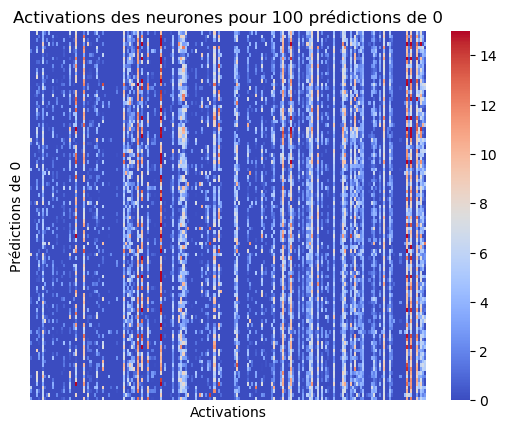

In [7]:
sns.heatmap(
            activations_reduced[activations["nb_pred"] == 0].head(100),
            cmap="coolwarm", vmax=15, xticklabels=False, yticklabels=False
            )
plt.title("Activations des neurones pour 100 prédictions de 0")
plt.xlabel("Activations")
plt.ylabel("Prédictions de 0")
plt.show()

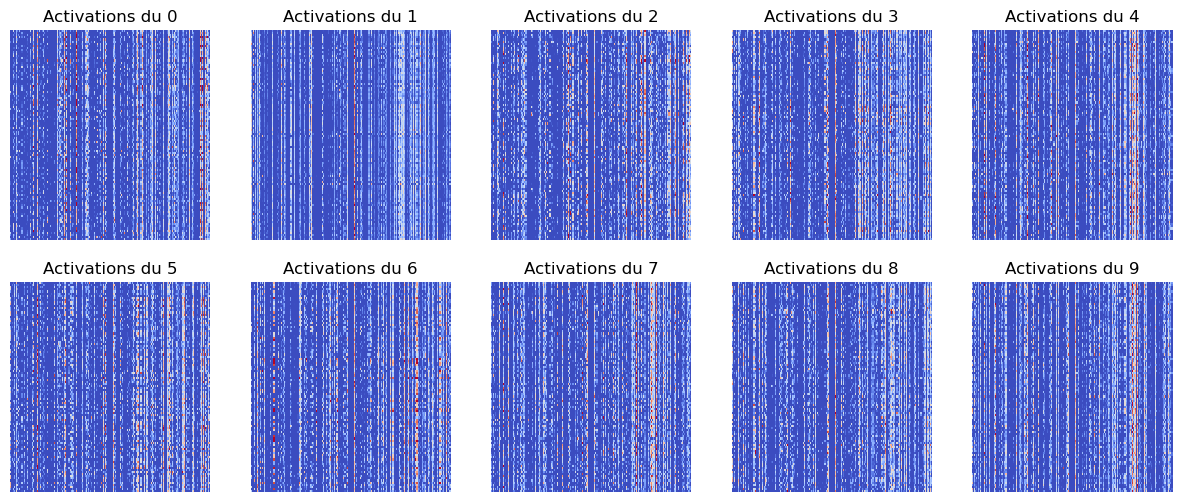

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    sns.heatmap(
            activations_reduced[activations["nb_pred"] == i].head(100),
            cmap="coolwarm",cbar=False , vmax=15, ax=ax
            )
    ax.set_title(f"Activations du {i}")  
    ax.axis("off") 
plt.show()

In [9]:
X = activations.iloc[:, 2:]
y = activations["nb_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.99


## Réduction de dimension

On va maintenant s'intéresser à la complexité du problème. Pour cela nous allons réduire la dimension des données d'activations.

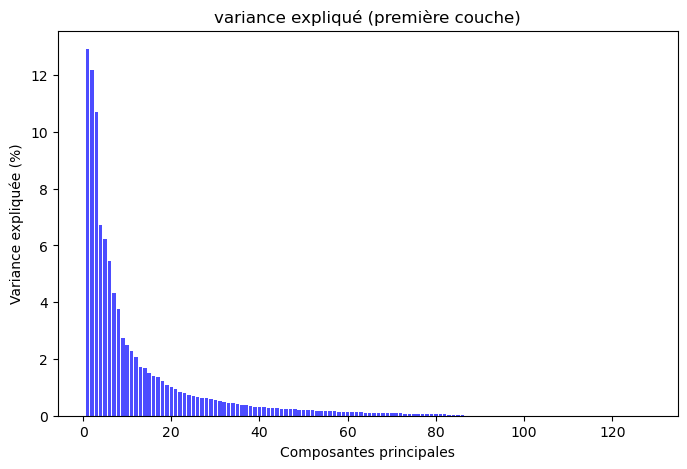

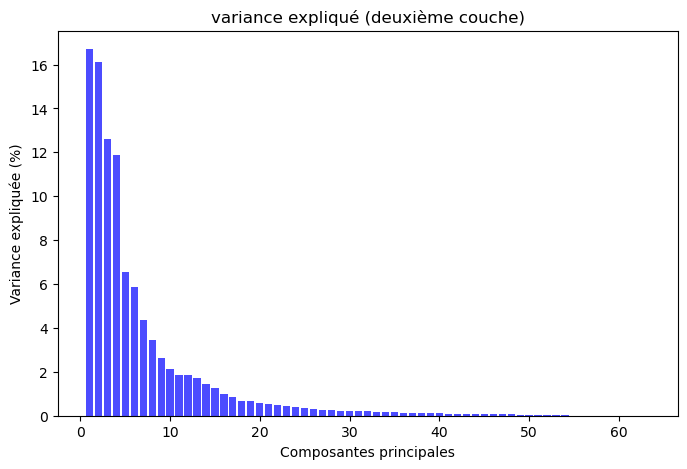

In [10]:
def plot_pca_var(data, title=""):
    data_normalized = StandardScaler().fit_transform(data)

    pca = PCA()
    x_pca = pca.fit_transform(data_normalized)

    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100, alpha=0.7, color='b')
    plt.xlabel("Composantes principales")
    plt.ylabel("Variance expliquée (%)")
    plt.title(title)
    plt.show()

plot_pca_var(activations_reduced.iloc[:,:128], "variance expliqué (première couche)")
plot_pca_var(activations_reduced.iloc[:,129:], "variance expliqué (deuxième couche)")




In [11]:
def normalize_reduce(data, n_components):
    data_normalized = StandardScaler().fit_transform(data)
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data_normalized)


first_layer_reduced = normalize_reduce(activations_reduced.iloc[:,:128], 5)
second_layer_reduced = normalize_reduce(activations_reduced.iloc[:,129:], 5)

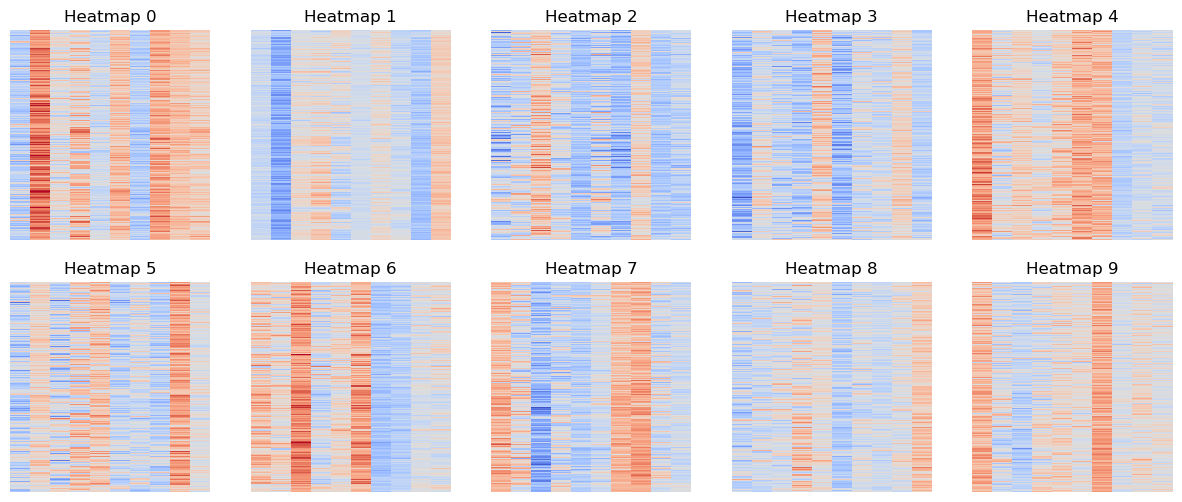

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    mask = activations["nb_pred"] == i
    data = np.concat((first_layer_reduced[mask], second_layer_reduced[mask]), axis=1)
    sns.heatmap(
            data,
            cmap="coolwarm",cbar=False , vmin=-10, vmax=10, ax=ax
            )
    ax.set_title(f"Heatmap {i}")  
    ax.axis("off") 
plt.show()

In [13]:
X = np.concat((first_layer_reduced, second_layer_reduced), axis=1)
y = activations["nb_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Problème de classification multiclasses
    "num_class": 10,               # Nombre de classes
    "max_depth": 4,               # Profondeur maximale des arbres
    "eta": 0.3,                   # Taux d'apprentissage (learning rate)
    "eval_metric": "mlogloss"     # Log-loss pour évaluer le modèle
}

num_round = 50
bst = xgb.train(params, dtrain, num_round)

preds = bst.predict(dtest)

accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.96


In [14]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.96


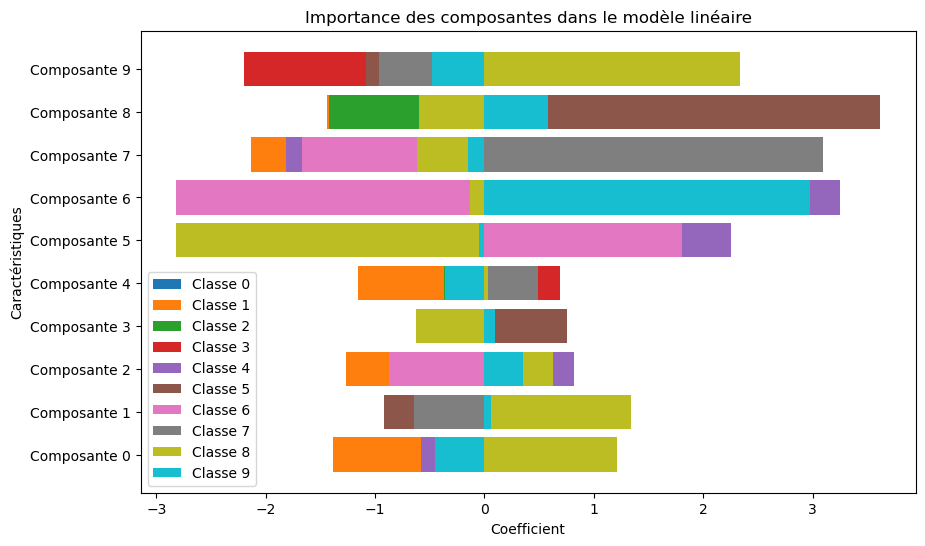

In [15]:
# Récupération des coefficients
coefficients = model.coef_  # Matrice (nb_classes, nb_features)
intercept = model.intercept_  # Biais du modèle

# Création d'un DataFrame pour afficher les coefficients
feature_names = [f"Composante {i}" for i in range(X.shape[1])]  
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[0]):  # Boucle sur les classes
    plt.barh(feature_names, coefficients[i], label=f"Classe {i}")

plt.xlabel("Coefficient")
plt.ylabel("Caractéristiques")
plt.title("Importance des composantes dans le modèle linéaire")
plt.legend()
plt.show()

In [16]:
def evaluate_logistic(X, y) -> float:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=100)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)


In [17]:
# Appliquer TruncatedSVD avec un nombre élevé de composantes
svd1 = TruncatedSVD(n_components=128-1)
svd2 = TruncatedSVD(n_components=64-1)
svd3 = TruncatedSVD(n_components=128+64-1)

svd1.fit(activations_reduced.iloc[:,:128])
svd2.fit(activations_reduced.iloc[:,129:])
svd3.fit(activations_reduced)

variance_cumulee1 = np.cumsum(svd1.explained_variance_ratio_)
variance_cumulee2 = np.cumsum(svd2.explained_variance_ratio_)
variance_cumulee3 = np.cumsum(svd3.explained_variance_ratio_)

variance_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

n_comps = {"first":[], "second":[], "mixed":[]}

for variance in variance_list:
    n_comps["first"].append(np.searchsorted(variance_cumulee1, variance) + 1)
    n_comps["second"].append(np.searchsorted(variance_cumulee2, variance) + 1)
    n_comps["mixed"].append(np.searchsorted(variance_cumulee3, variance) + 1)

In [18]:
warnings.filterwarnings("ignore", category=UserWarning)
accs = {"mixed":[], "first":[], "second":[]}

for i in range(len(variance_list)):
    svd1 = TruncatedSVD(n_components=n_comps["first"][i])
    svd2 = TruncatedSVD(n_components=n_comps["second"][i])
    svd3 = TruncatedSVD(n_components=n_comps["mixed"][i])


    first_layer = svd1.fit_transform(activations_reduced.iloc[:,:128])
    second_layer = svd2.fit_transform(activations_reduced.iloc[:,129:])
    mixed_layer = svd3.fit_transform(activations_reduced)

    accs["mixed"].append(evaluate_logistic(mixed_layer, activations["nb_pred"]))
    accs["first"].append(evaluate_logistic(first_layer, activations["nb_pred"]))
    accs["second"].append(evaluate_logistic(second_layer, activations["nb_pred"]))

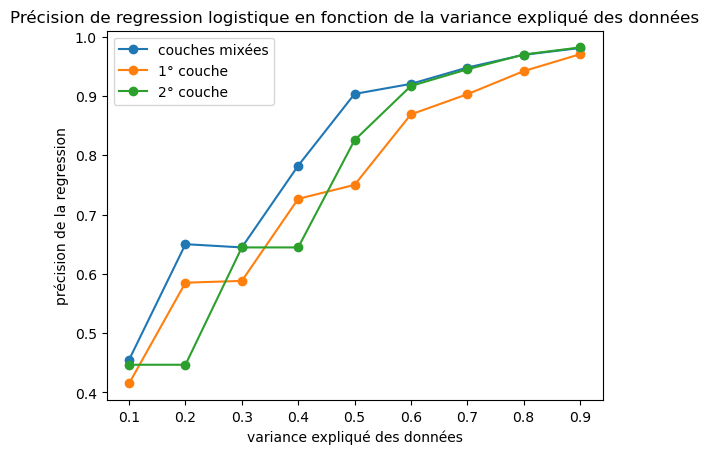

In [19]:
plt.plot(variance_list, accs["mixed"], marker='o', linestyle='-', label="couches mixées")
plt.plot(variance_list, accs["first"], marker='o', linestyle='-', label="1° couche")
plt.plot(variance_list, accs["second"], marker='o', linestyle='-', label="2° couche")
plt.xlabel("variance expliqué des données")
plt.ylabel("précision de la regression")
plt.xticks(variance_list)
plt.legend()
plt.title("Précision de regression logistique en fonction de la variance expliqué des données")
plt.show()